# Data augmentation

## Recap

In previous tutorials we learned how to create Source datasets, and how to transform them.

For simplicity we addded all the layers from previous tutorials to `layers02.py`. Let's import them:

In [1]:
from layers02 import *

from connectome import Chain

In [2]:
source = HeLa(root='DIC-C2DH-HeLa')
key = source.ids[0]

dataset = Chain(
    source, 
    Binarize(),
    Zoom(factor=0.25),
    Crop(),
)

x, y = dataset.image(key), dataset.mask(key)

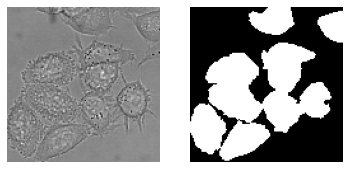

In [3]:
import matplotlib.pyplot as plt


plt.subplot(1, 2, 1)
plt.imshow(x, cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(y, cmap='gray')
plt.axis('off');

# Data Augmentation

Data augmentation is a useful technique to increase the dataset size by applying random transformation to the data.

So far we only used **pure functions** in our transforms: their output only depends on the input arguments. `connectome` heavily relies on this property because impure functions (e.g. that generate random value) might cause a lot of trouble in your pipelines.

However **impure functions** are sometimes very useful, and we can use them in our transforms with the `impure` decorator. Let's write a layer that randomly rotates the image and the mask:

In [4]:
from connectome import impure
import numpy as np
from skimage.transform import rotate


class Rotate(Transform):
    @impure
    def _degrees():
        return np.random.uniform(0, 360)
    
    def image(image, _degrees):
        return rotate(image, _degrees, mode='reflect', order=1)
    
    def mask(mask, _degrees):
        return rotate(mask.astype(float), _degrees, mode='reflect', order=1) >= 0.5

We already saw such transforms, except the `impure` decorator. It is important to annotate all impure functions with it, because this allows `connectome` to perform additional checks which will help you not to shoot yourself in the leg.

In [5]:
augmented = dataset >> Rotate()

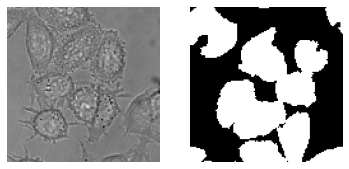

In [6]:
x, y = augmented.image(key), augmented.mask(key)

plt.subplot(1, 2, 1)
plt.imshow(x, cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(y, cmap='gray')
plt.axis('off');

Wait, something is wrong. The image and the mask are not consistent anymore! The problem is in this line:

```python
x, y = augmented.image(key), augmented.mask(key)
```

We are making separate calls to `image` and `mask`. There is no way for `connectome` to figure out that they must be consistent. We need to compute them both in a single call, that's how you do it:

In [7]:
loader = augmented._compile(['image', 'mask'])

We created a new function, that returns a tuple of `(image, mask)` pairs:

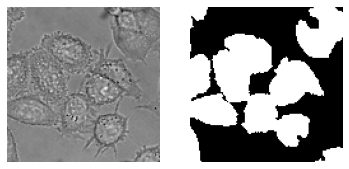

In [8]:
x, y = loader(key)

plt.subplot(1, 2, 1)
plt.imshow(x, cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(y, cmap='gray')
plt.axis('off');

That's more like it. The image and mask are consistent again, but each time different:

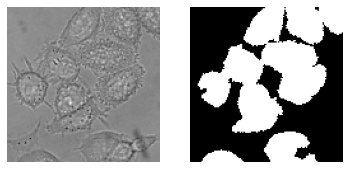

In [9]:
x, y = loader(key)

plt.subplot(1, 2, 1)
plt.imshow(x, cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(y, cmap='gray')
plt.axis('off');

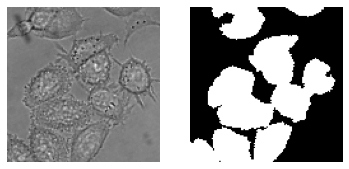

In [10]:
x, y = loader(key)

plt.subplot(1, 2, 1)
plt.imshow(x, cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(y, cmap='gray')
plt.axis('off');

# Image noising

Until now we only used `impure` for internal parameters, but we can go further and make outputs impure:

In [11]:
class NormalNoise(Transform):
    __inherit__ = 'mask'
    
    @impure
    def image(image):
        return image + np.random.normal(scale=10, size=image.shape)

In [12]:
augmented = dataset >> Rotate() >> NormalNoise()

loader = augmented._compile(['image', 'mask'])

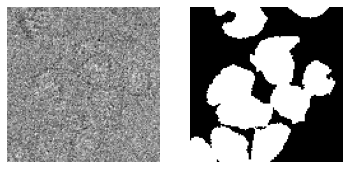

In [13]:
x, y = loader(key)

plt.subplot(1, 2, 1)
plt.imshow(x, cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(y, cmap='gray')
plt.axis('off');

Maybe that's too much noise, let's move the `scale` parameter out:

In [14]:
class NormalNoise(Transform):
    __inherit__ = 'mask'
    _scale: float = 1
    
    @impure
    def image(image, _scale):
        return image + np.random.normal(scale=_scale, size=image.shape)

In [15]:
augmented = dataset >> Rotate() >> NormalNoise(scale=3)

loader = augmented._compile(['image', 'mask'])

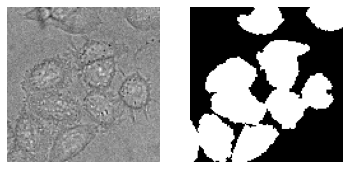

In [16]:
x, y = loader(key)

plt.subplot(1, 2, 1)
plt.imshow(x, cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(y, cmap='gray')
plt.axis('off');

Note that the `_scale` parameter has a default value of 1

Note how both the image and the mask got cropped. This is _data consistency_ at work!

That's all for now. 

The main points to remember while working with data augmentation:

1. Annotate your impure functions with `impure`
2. Use `._compile` to make a function, which loads you data in a single call

See you next time!